#Import Libraries

In [ ]:
# import data manipulation libraries
import numpy as np
import pandas as pd

# import library to display plots/images
import matplotlib.pyplot as plt

# import tensorflow libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# import standard libraries to deal with files
import pathlib
import shutil

# Utility Functions

In [ ]:
# create huge numpy array and save it to disk
def make_huge_data(path: str) -> None:
    huge_data_file = pathlib.Path(path)
    huge_data_shape = (3000, 256, 256, 3)
    huge_data_dtype = np.float64

    if not huge_data_file.exists():
        huge_data = np.random.rand(*huge_data_shape).astype(huge_data_dtype)
        np.save(huge_data_file, huge_data)
        del huge_data

In [ ]:
# setup the huge data file
HUGE_DATA_FILE = "/content/huge_data.npy"
make_huge_data(HUGE_DATA_FILE)

In [ ]:
# shows original and augmented image side by side
def visualize_augmentation(original: tf.Tensor, augmented: tf.Tensor) -> None:
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

In [ ]:
# returns a class name given the index number
def get_class_name(info: tfds.core.dataset_info.DatasetInfo, 
                   class_num: int) -> str:
    return info.features['label'].int2str(class_num)

# Outline
---
1. Basics of `tf.data.Dataset`
> 1.1 Methods for a manipulating `Dataset`\
> 1.2 Creating pipelines by chaining methods\
> 1.3 Working with a structured `Dataset`

2. Creating `Dataset` from data in memory/disk
> 2.1 `Dataset` from a NumPy array\
> 2.2 `Dataset` from a structured image directory\
> 2.3 `Dataset` from a CSV file

3. Create a image classification model using data pipelines
> 3.1 Load Dataset from TF Hub\
> 3.2 Build the pipeline\
> 3.3 Define the model\
> 3.4 Train the model\
> 3.5 Manually evaluate the model

# Basic Mechanics of TF Datasets
---


In [ ]:
lst = list(range(10))
dataset = tf.data.Dataset.from_tensor_slices(lst)

In [ ]:
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [ ]:
dataset[3]

TypeError: ignored

In [ ]:
for x in dataset:
    print(x)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [ ]:
next(iter(dataset))

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [ ]:
list(iter(dataset))

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 <tf.Tensor: shape=(), dtype=int32, numpy=6>,
 <tf.Tensor: shape=(), dtype=int32, numpy=7>,
 <tf.Tensor: shape=(), dtype=int32, numpy=8>,
 <tf.Tensor: shape=(), dtype=int32, numpy=9>]

## Manipulating Datasets

### Dataset.shuffle()

**TensorFlow docs description:**
```
tf.Data.Dataset.shuffle(
    buffer_size, 
    seed=None, 
    reshuffle_each_iteration=None
)
```

- Randomly shuffles the elements of this dataset.

- This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

[Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)



In [ ]:
list(iter(dataset.shuffle(10)))

[<tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=8>,
 <tf.Tensor: shape=(), dtype=int32, numpy=7>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=9>,
 <tf.Tensor: shape=(), dtype=int32, numpy=6>,
 <tf.Tensor: shape=(), dtype=int32, numpy=4>]

In [ ]:
list(iter(dataset.shuffle(2)))

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 <tf.Tensor: shape=(), dtype=int32, numpy=6>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=7>,
 <tf.Tensor: shape=(), dtype=int32, numpy=9>,
 <tf.Tensor: shape=(), dtype=int32, numpy=8>]

In [ ]:
list(iter(dataset.shuffle(20000)))

### Dataset.filter()

**TensorFlow docs description:**\
`tf.Data.Dataset.filter(predicate)`:

- Filters this dataset according to `predicate`.

[Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#filter)



In [ ]:
list(iter(dataset.filter(lambda x: x % 2 == 0)))

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 <tf.Tensor: shape=(), dtype=int32, numpy=6>,
 <tf.Tensor: shape=(), dtype=int32, numpy=8>]

### Dataset.map()

The `Dataset.map` method is similar to python's `map` method where we can map a function to each element in the dataset.

**TensorFlow docs description:**
```
tf.Data.Dataset.map(
    map_func,
    num_parallel_calls=None, 
    deterministic=None
)
```

- Maps `map_func` across the elements of this dataset.

- This transformation applies `map_func` to each element of this dataset, and returns a new dataset containing the transformed elements, in the same order as they appeared in the input. 

[Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)

In [ ]:
list(iter(dataset.map(lambda x: x*2)))

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 <tf.Tensor: shape=(), dtype=int32, numpy=6>,
 <tf.Tensor: shape=(), dtype=int32, numpy=8>,
 <tf.Tensor: shape=(), dtype=int32, numpy=10>,
 <tf.Tensor: shape=(), dtype=int32, numpy=12>,
 <tf.Tensor: shape=(), dtype=int32, numpy=14>,
 <tf.Tensor: shape=(), dtype=int32, numpy=16>,
 <tf.Tensor: shape=(), dtype=int32, numpy=18>]

### Dataset.take()

The `take` method allows us to construct a new dataset taking a specified number of elements from our original dataset

**TensorFlow docs description:**\
`tf.Data.Dataset.take(count)`:
- Creates a `Dataset` with at most `count` elements from this dataset.

[Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)

In [ ]:
list(iter(dataset.take(3)))

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>]

### Dataset.batch()

The `batch` method essentially groups together our dataset elements into a specified batch size. This is a really useful method for when we train our models, as batching essentially allows us to show a limited number of samples to the model every time the model is updated in the training phase.

**TensorFlow docs description:**
```
tf.Data.Dataset.batch(
    batch_size, 
    drop_remainder=False, 
    num_parallel_calls=None, 
    deterministic=None
)
```
- Combines consecutive elements of this dataset into batches.

- The components of the resulting element will have an additional outer dimension, which will be `batch_size` (or `N % batch_size` for the last element if `batch_size` does not divide the number of input elements `N` evenly and `drop_remainder` is `False`).

- If your program depends on the batches having the same outer dimension, you should set the `drop_remainder` argument to `True` to prevent the smaller batch from being produced.

[Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch)

In [ ]:
dataset.batch(3)

<BatchDataset shapes: (None,), types: tf.int32>

In [ ]:
dataset.batch(3, drop_remainder=True)

<BatchDataset shapes: (3,), types: tf.int32>

### Dataset.unbatch()

The `unbatch` method undoes the batch operation and removes a dimension

[Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch)

In [ ]:
list(iter(dataset.batch(3).unbatch()))

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 <tf.Tensor: shape=(), dtype=int32, numpy=6>,
 <tf.Tensor: shape=(), dtype=int32, numpy=7>,
 <tf.Tensor: shape=(), dtype=int32, numpy=8>,
 <tf.Tensor: shape=(), dtype=int32, numpy=9>]

## Optimizing pipeline efficiency

### Dataset.cache()

Caching allows us to cache a section of the pipeline to improve the performance of subsequent iterations on the pipeline.

**TensorFlow docs description:**
```
tf.Data.Dataset.cache(
    filename=''
)
```
- Caches the elements in this dataset.

- The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data.

[Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache)

In [ ]:
dataset.batch(3).cache()

<CacheDataset shapes: (None,), types: tf.int32>

### Dataset.prefetch()

Prefetching essentially allows us to specify the number of samples to prepare in the background while the current sample is being used to train a model. It's a vital component of data pipelines allowing us to improve the overall speed of training ML models

**TensorFlow docs description:**
```
tf.Data.Dataset.prefetch(
    buffer_size
)
```
- Creates a Dataset that prefetches elements from this dataset.

- **Most dataset input pipelines should end with a call to prefetch.** This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

[Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)

## Chaining methods (a.k.a data pipelines)

Now that you're more familiar with datasets and their methods, let's look at how we can build pipelines from them.

All of the methods shown above don't actually modify the original dataset; instead, they produce a new modified dataset. So we can use this to chain together methods and create a pipeline with our datasets.

In [ ]:
pipeline = (dataset.map(lambda x: x + 1, num_parallel_calls=tf.data.AUTOTUNE)
                   .filter(lambda x: x > 3)
                   .cache()
                   .shuffle(10)
                   .batch(2, num_parallel_calls=tf.data.AUTOTUNE)
                   .prefetch(tf.data.AUTOTUNE))

list(iter(pipeline))

[<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 6], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 8, 10], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([7, 9], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>]

---

## Working with Structured Datasets

In [ ]:
features = np.random.rand(4, 3, 3)
labels = np.random.rand(4)

structured_ds = tf.data.Dataset.from_tensor_slices((labels, features))

In [ ]:
structured_ds

<TensorSliceDataset shapes: ((), (3, 3)), types: (tf.float64, tf.float64)>

In [ ]:
for x in structured_ds:
    print(x)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.6727292636099583>, <tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[0.42401389, 0.4242513 , 0.12906376],
       [0.53668053, 0.00355094, 0.31381617],
       [0.0545894 , 0.98779653, 0.1443377 ]])>)
(<tf.Tensor: shape=(), dtype=float64, numpy=0.32493707798061366>, <tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[0.40857591, 0.42403856, 0.98137063],
       [0.2796856 , 0.78756419, 0.89955269],
       [0.70037761, 0.92456815, 0.8258271 ]])>)
(<tf.Tensor: shape=(), dtype=float64, numpy=0.44493863991153393>, <tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[0.67488696, 0.80993487, 0.86199238],
       [0.40673097, 0.47512241, 0.14601514],
       [0.92749522, 0.77778587, 0.03202638]])>)
(<tf.Tensor: shape=(), dtype=float64, numpy=0.6584003708708235>, <tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[0.31305045, 0.62108923, 0.50657551],
       [0.52458716, 0.9976162 , 0.58861504],
       [0.84441804, 0.28188044, 0.6907047 

In [ ]:
type(next(iter(structured_ds)))

tuple

In [ ]:
for label, feature in structured_ds:
    print(label.numpy(), feature.numpy())

0.6727292636099583 [[0.42401389 0.4242513  0.12906376]
 [0.53668053 0.00355094 0.31381617]
 [0.0545894  0.98779653 0.1443377 ]]
0.32493707798061366 [[0.40857591 0.42403856 0.98137063]
 [0.2796856  0.78756419 0.89955269]
 [0.70037761 0.92456815 0.8258271 ]]
0.44493863991153393 [[0.67488696 0.80993487 0.86199238]
 [0.40673097 0.47512241 0.14601514]
 [0.92749522 0.77778587 0.03202638]]
0.6584003708708235 [[0.31305045 0.62108923 0.50657551]
 [0.52458716 0.9976162  0.58861504]
 [0.84441804 0.28188044 0.6907047 ]]


In [ ]:
def map_fn(label, feature):
    return label + 1, feature + 1

list(iter(structured_ds.map(map_fn)))

[(<tf.Tensor: shape=(), dtype=float64, numpy=1.6727292636099582>,
  <tf.Tensor: shape=(3, 3), dtype=float64, numpy=
  array([[1.42401389, 1.4242513 , 1.12906376],
         [1.53668053, 1.00355094, 1.31381617],
         [1.0545894 , 1.98779653, 1.1443377 ]])>),
 (<tf.Tensor: shape=(), dtype=float64, numpy=1.3249370779806138>,
  <tf.Tensor: shape=(3, 3), dtype=float64, numpy=
  array([[1.40857591, 1.42403856, 1.98137063],
         [1.2796856 , 1.78756419, 1.89955269],
         [1.70037761, 1.92456815, 1.8258271 ]])>),
 (<tf.Tensor: shape=(), dtype=float64, numpy=1.444938639911534>,
  <tf.Tensor: shape=(3, 3), dtype=float64, numpy=
  array([[1.67488696, 1.80993487, 1.86199238],
         [1.40673097, 1.47512241, 1.14601514],
         [1.92749522, 1.77778587, 1.03202638]])>),
 (<tf.Tensor: shape=(), dtype=float64, numpy=1.6584003708708235>,
  <tf.Tensor: shape=(3, 3), dtype=float64, numpy=
  array([[1.31305045, 1.62108923, 1.50657551],
         [1.52458716, 1.9976162 , 1.58861504],
        

The methods introduced above are only the tip of the iceberg, if you want to see all the available methods, visit the [Dataset documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#methods_2)

# Create Datasets from memory/disk
---

## Create a Dataset from NumPy Array

In [ ]:
file_byte_size = pathlib.Path(HUGE_DATA_FILE).stat().st_size
print(f'{(file_byte_size/10**9):.2f}GB')

4.72GB


In [ ]:
# load huge dataset using memmap
huge_data = np.load(HUGE_DATA_FILE, mmap_mode='r')

In [ ]:
# create labels for the huge dataset
huge_data_labels = np.random.randint(0, 10, 3000)

In [ ]:
huge_dataset = tf.data.Dataset.from_tensor_slices((huge_data_labels, huge_data))

In [ ]:
huge_dataset

<TensorSliceDataset shapes: ((), (256, 256, 3)), types: (tf.int64, tf.float64)>

In [ ]:
next(iter(huge_dataset))

(<tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(256, 256, 3), dtype=float64, numpy=
 array([[[0.07082251, 0.19034889, 0.92724563],
         [0.62400296, 0.08650253, 0.01994111],
         [0.40921477, 0.29538659, 0.76279232],
         ...,
         [0.82789282, 0.09305196, 0.82017849],
         [0.7136753 , 0.03038662, 0.37640307],
         [0.89105458, 0.46615868, 0.51506323]],
 
        [[0.19518286, 0.84567257, 0.65162804],
         [0.8212018 , 0.88698015, 0.46943308],
         [0.4528354 , 0.18339935, 0.12827013],
         ...,
         [0.63798446, 0.86046113, 0.28220249],
         [0.30134933, 0.86782587, 0.33880877],
         [0.9558739 , 0.62738843, 0.69809124]],
 
        [[0.60214767, 0.64217469, 0.99364623],
         [0.98625653, 0.33243864, 0.34564886],
         [0.66823289, 0.07055324, 0.50473661],
         ...,
         [0.51746903, 0.52141854, 0.61099109],
         [0.50884214, 0.76545396, 0.48947511],
         [0.80542833, 0.20546059, 0.21570386]],
 
 

In [ ]:
for label, data in huge_dataset.take(1):
  print(label)
  print(data)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(
[[[0.07082251 0.19034889 0.92724563]
  [0.62400296 0.08650253 0.01994111]
  [0.40921477 0.29538659 0.76279232]
  ...
  [0.82789282 0.09305196 0.82017849]
  [0.7136753  0.03038662 0.37640307]
  [0.89105458 0.46615868 0.51506323]]

 [[0.19518286 0.84567257 0.65162804]
  [0.8212018  0.88698015 0.46943308]
  [0.4528354  0.18339935 0.12827013]
  ...
  [0.63798446 0.86046113 0.28220249]
  [0.30134933 0.86782587 0.33880877]
  [0.9558739  0.62738843 0.69809124]]

 [[0.60214767 0.64217469 0.99364623]
  [0.98625653 0.33243864 0.34564886]
  [0.66823289 0.07055324 0.50473661]
  ...
  [0.51746903 0.52141854 0.61099109]
  [0.50884214 0.76545396 0.48947511]
  [0.80542833 0.20546059 0.21570386]]

 ...

 [[0.35938713 0.99971233 0.46422799]
  [0.34748776 0.11751447 0.28605348]
  [0.48557094 0.67018179 0.4307371 ]
  ...
  [0.63374582 0.65552075 0.06815624]
  [0.28537745 0.32647645 0.45217651]
  [0.46023034 0.8072319  0.33941951]]

 [[0.66828316 0.26165232 0.

## Create a Dataset from structured image directory

###Download the flowers directory from tensorflow hub

[TF Datasets Catalog](https://www.tensorflow.org/datasets/catalog/overview)

**TensorFlow docs description:**
```
tf.keras.utils.get_file(
    fname, 
    origin, 
    untar=False,
    md5_hash=None, 
    file_hash=None,
    cache_subdir='datasets', 
    hash_algorithm='auto',
    extract=False, 
    archive_format='auto', 
    cache_dir=None
)
```

- Downloads a file from a URL if it not already in the cache.

- By default the file at the url `origin` is downloaded to the `cache_dir ~/.keras`, placed in the cache_subdir `datasets`, and given the filename `fname`. The final location of a file `example.txt` would therefore be `~/.keras/datasets/example.txt`.

[Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file)

In [ ]:
flowers_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
flowers_dir

'/root/.keras/datasets/flower_photos'

In [ ]:
shutil.move(flowers_dir, '/content/flower_photos')

'/content/flower_photos'

In [ ]:
flowers_dir = '/content/flower_photos'

###Load dataset from an image directory

`tf.keras.preprocessing.image_dataset_from_directory()`

**TensorFlow docs description:**
```
tf.keras.preprocessing.image_dataset_from_directory(
    directory, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=32, 
    image_size=(256,
    256), 
    shuffle=True, 
    seed=None,
    validation_split=None, 
    subset=None,
    interpolation='bilinear', 
    follow_links=False, 
    smart_resize=False
)
```

- Generates a `tf.data.Dataset` from image files in a directory.

- If your directory structure is:
```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

- Then calling `image_dataset_from_directory(main_directory, labels='inferred')` will return a `Dataset` that yields batches of images from the subdirectories `class_a` and `class_b`, together with labels `0` and `1` (`0` corresponding to `class_a` and `1` corresponding to `class_b`).

[Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

In [ ]:
flowers_dataset = tf.keras.preprocessing.image_dataset_from_directory(flowers_dir)

Found 3670 files belonging to 5 classes.


In [ ]:
flowers_dataset.unbatch()

<_UnbatchDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

## Create Dataset from CSV file

### Create a Dataset from a CSV loaded into a DataFrame

In [ ]:
housing_csv_file = '/content/sample_data/california_housing_train.csv'
df = pd.read_csv(housing_csv_file)

In [ ]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [ ]:
housing_labels = df.loc[:, 'median_house_value']
housing_features = df.drop(columns='median_house_value')

In [ ]:
housing_labels.head()

0    66900.0
1    80100.0
2    85700.0
3    73400.0
4    65500.0
Name: median_house_value, dtype: float64

In [ ]:
housing_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250


In [ ]:
housing_dataset = tf.data.Dataset.from_tensor_slices((housing_labels.values, housing_features.values))

In [ ]:
housing_dataset

<TensorSliceDataset shapes: ((), (8,)), types: (tf.float64, tf.float64)>

### Create a Dataset directly from the CSV file

**TensorFlow docs description:**
```
tf.data.experimental.make_csv_dataset(
    file_pattern, 
    batch_size, 
    column_names=None, 
    column_defaults=None,
    label_name=None, 
    select_columns=None, 
    field_delim=',',
    use_quote_delim=True, 
    na_value='', 
    header=True, 
    num_epochs=None,
    shuffle=True, 
    shuffle_buffer_size=10000, 
    shuffle_seed=None,
    prefetch_buffer_size=None, 
    num_parallel_reads=None, 
    sloppy=False,
    num_rows_for_inference=100, 
    compression_type=None, 
    ignore_errors=False
)
```

- Reads CSV files into a dataset, where each element of the dataset is a (features, labels) tuple that corresponds to a batch of CSV rows. The features dictionary maps feature column names to `Tensor`s containing the corresponding feature data, and labels is a `Tensor` containing the batch's label data.

[Documentation](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset)

In [ ]:
housing_dataset = tf.data.experimental.make_csv_dataset(housing_csv_file, label_name='median_house_value', batch_size=1)

In [ ]:
housing_dataset

<PrefetchDataset shapes: (OrderedDict([(longitude, (1,)), (latitude, (1,)), (housing_median_age, (1,)), (total_rooms, (1,)), (total_bedrooms, (1,)), (population, (1,)), (households, (1,)), (median_income, (1,))]), (1,)), types: (OrderedDict([(longitude, tf.float32), (latitude, tf.float32), (housing_median_age, tf.float32), (total_rooms, tf.float32), (total_bedrooms, tf.float32), (population, tf.float32), (households, tf.float32), (median_income, tf.float32)]), tf.float32)>

# Full workflow example
---

## Load Dataset from TensorFlow Hub

**Load the `tf_flowers` dataset from the [TensorFlow Dataset catalog](https://www.tensorflow.org/datasets/catalog/overview)**

In [ ]:
(train_ds, val_ds), info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

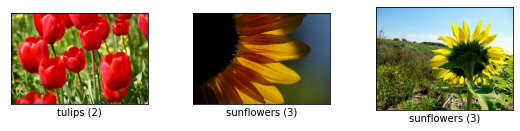

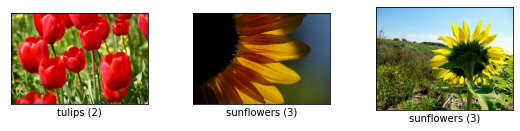

In [ ]:
tfds.show_examples(train_ds.take(3), info)

In [ ]:
info.features['label'].int2str(3)

'sunflowers'

In [ ]:
info.features['label'].int2str(2)

'tulips'

In [ ]:
img, _ = next(iter(train_ds))

## Build Pipeline

Create a function for resizing and rescaling the image

In [ ]:
def resize_and_rescale(image, label, size):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size)
    image = image / 255.0
    return image, label

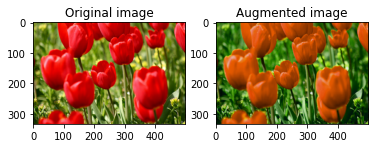

In [ ]:
img, label = next(iter(train_ds))

resized_img, _ = img_augmentations(img, label)

visualize_augmentation(img, resized_img)

Visualize the function results

Create a function for augmentating the image

In [ ]:
def img_augmentations(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 1, 2)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_hue(image, 0.1)
    return image, label

Create our pipeline

In [ ]:
IMG_SIZE = (256, 256)

pipeline = (train_ds
                .map(lambda img, label: resize_and_rescale(img, label, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
                .map(img_augmentations, num_parallel_calls=tf.data.AUTOTUNE)
                )

Visualize the pipeline results

In [ ]:
def show(image, label):
    plt.imshow(image)
    plt.title(str(label.numpy()))

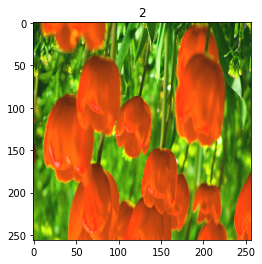

In [ ]:
show(*next(iter(pipeline)))

## Define the Model

We will be using the [MobileNet V3 Small](https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5) (input image size must be 224x224)

In [ ]:
model_handle = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5'

In [ ]:
IMG_SIZE = (224, 224)
input_shape = IMG_SIZE + (3,)

In [ ]:
input_shape

(224, 224, 3)

In [ ]:
num_classes = info.features['label'].num_classes

In [ ]:
# define the model structure
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    hub.KerasLayer(model_handle),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# build and summarize the model
model.build((None,)+input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              2555993   
_________________________________________________________________
dense (Dense)                (None, 5)                 5010      
Total params: 2,561,003
Trainable params: 5,010
Non-trainable params: 2,555,993
_________________________________________________________________


In [ ]:
# compile the model using an Adam optimizer and a Sparse Categorical Crossentrophy loss function
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
train_ds_size = train_ds.cardinality().numpy()
val_ds_size = val_ds.cardinality().numpy()

train_processed = (train_ds
                   .map(lambda img, label: resize_and_rescale(img, label, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
                   .cache()
                   .map(img_augmentations, num_parallel_calls=tf.data.AUTOTUNE)
                   .shuffle(train_ds_size)
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.AUTOTUNE)
                   )

val_processed = (val_ds
                 .map(lambda img, label: resize_and_rescale(img, label, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
                 .cache()
                 .shuffle(val_ds_size)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE)
                 )

## Train Model

In [ ]:
hist = model.fit(
    train_processed,
    validation_data=val_processed,
    epochs=5,
    steps_per_epoch=10,
    validation_steps=10
)

Epoch 1/5
10/10 [==============================] - 25s 897ms/step - loss: 1.2809 - accuracy: 0.5688 - val_loss: 0.6681 - val_accuracy: 0.7656
Epoch 2/5
10/10 [==============================] - 6s 674ms/step - loss: 0.8505 - accuracy: 0.7312 - val_loss: 0.5709 - val_accuracy: 0.8219
Epoch 3/5
10/10 [==============================] - 6s 674ms/step - loss: 0.6368 - accuracy: 0.8219 - val_loss: 0.5725 - val_accuracy: 0.8500
Epoch 4/5
10/10 [==============================] - 6s 674ms/step - loss: 0.7830 - accuracy: 0.7781 - val_loss: 0.5634 - val_accuracy: 0.8375
Epoch 5/5
10/10 [==============================] - 6s 667ms/step - loss: 0.6570 - accuracy: 0.8094 - val_loss: 0.5141 - val_accuracy: 0.8656


## Create Predictions

In [ ]:
# grab one sample from the validation dataset
test_img, test_label = next(iter(val_processed.unbatch().take(1)))

In [ ]:
# create the predictions
prediction = model.predict(np.expand_dims(test_img, axis=0))
prediction

array([[9.9998081e-01, 1.8631539e-05, 1.4111511e-08, 6.1457905e-07,
        3.8416321e-08]], dtype=float32)

Text(0.5, 1.0, 'dandelion')

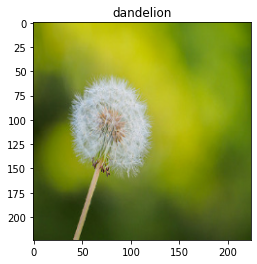

In [ ]:
# show the image and its predicted numerical label
plt.imshow(test_img)
plt.title(get_class_name(info, prediction.argmax()))

Create a function to show the prediction and actual label for one batch from the validation pipeline

In [ ]:
def show_predictions(processed_val_dataset, info):
    processed_val_dataset = processed_val_dataset.unbatch()

    for test_img, test_label in processed_val_dataset:
        plt.figure()
        plt.axis('off')
        plt.imshow(test_img)
        prediction = model.predict(np.expand_dims(test_img, axis=0))
        prediction_label = get_class_name(info, prediction.argmax()) 
        actual_label = get_class_name(info, test_label.numpy())
        plt.title(f'Predicted: {prediction_label}, Actual: {actual_label}')

In [ ]:
show_predictions(val_processed.take(1), info)

This cell output is too large and can only be displayed while logged in.


# Conclusion
---
\
In this workshop, you have learned how to:
1. Create a TF Dataset from arrays, CSV, and a structured image directory
2. Manipulate the Datasets and form data pipelines
3. Use data pipelines for an image classification task

\

**Social Media Plugs:**

Data Science Club Discord: https://discord.gg/JebYaJtt. \

Youtube (for previously recorded workshops): https://www.youtube.com/channel/UCknY88pglf2xz_S72WHIDxg


# Thank you! Any questions?